### Confusion Matrix

In [1]:
%autosave 0
import warnings
warnings.filterwarnings(action='ignore')

import os

import numpy as np
import pandas as pd
import seaborn as sb

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt

from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)           # 맑은 고딕 폰트 지정
plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline  

Autosave disabled


In [2]:
data = np.loadtxt('./wine.csv', delimiter=",", dtype=np.float64)
print(type(data))
print(data.shape)

<class 'numpy.ndarray'>
(6497, 13)


In [3]:
X = data[:, 0:12]
print(X.shape)
Y = data[:, 12]
print(Y.shape)

(6497, 12)
(6497,)


In [4]:
# 출력 결과가 Sigmoid이으로 학습안됨
# red wine: 1 -> 11
# white wine: 0 -> 10
for i in range(len(Y)):
    if Y[i] == 0:   # White wine
        Y[i] = 10
    else:
        Y[i] = 11   # Red wine 이면

In [5]:
# 0과 1을 바꿈
# red wine: 11 -> 0
# white wine: 10 -> 1
for i in range(len(Y)):
    if Y[i] == 11: # Red wine 이면
        Y[i] = 0
    else:
        Y[i] = 1    # White wine

In [6]:
# train_test_split 분할을 통한 훈련, 검증, 테스트 데이터의 분리
seed = 0
# 90%: 분할대기(x_train_all), 10%: 테스트(x_test)
x_train_all, x_test, y_train_all, y_test = train_test_split(X, Y,
                                                          stratify=Y,
                                                          test_size=0.1,
                                                          random_state=seed)
# 나머지 데이터 90%를 분할, 70%: 훈련(x_train), 30%: 검증(x_val)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                  stratify=y_train_all,
                                                  test_size=0.3,
                                                  random_state=seed)

print(y_val[0:100])
print(y_val.shape)

[1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0.
 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1.
 1. 0. 1. 1.]
(1755,)


In [7]:
print(y_train[0:10])
print(y_train.shape)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(4092,)


In [8]:
print(y_val[0:10])
print(y_val.shape)

[1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
(1755,)


In [9]:
print(y_test[0:10])
print(y_test.shape)

[1. 0. 1. 1. 1. 1. 1. 0. 0. 1.]
(650,)


In [10]:
model = Sequential()
# model.add(Dense(64, input_dim=12, activation='linear')) # 첫번째 은닉층
model.add(Dense(64, input_shape=(12, ), activation='relu')) # 첫번째 은닉층
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # 출력층, 입력: 10, 출력 1

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

# 최소 오차 5번 나오면 자동 종료
early_stopping = EarlyStopping(monitor='loss', patience=2)


# 학습
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                 epochs=1000, 
                 batch_size=10, callbacks=[early_stopping])

Train on 4092 samples, validate on 1755 samples
Epoch 1/1000
4092/4092 [==============================] - 2s 381us/sample - loss: 0.2138 - accuracy: 0.9279 - val_loss: 0.1971 - val_accuracy: 0.9254
Epoch 2/1000
4092/4092 [==============================] - 1s 187us/sample - loss: 0.1828 - accuracy: 0.9399 - val_loss: 0.1725 - val_accuracy: 0.9350
Epoch 3/1000
4092/4092 [==============================] - 1s 179us/sample - loss: 0.1488 - accuracy: 0.9489 - val_loss: 0.1535 - val_accuracy: 0.9333
Epoch 4/1000
4092/4092 [==============================] - 1s 184us/sample - loss: 0.1371 - accuracy: 0.9541 - val_loss: 0.1488 - val_accuracy: 0.9447
Epoch 5/1000
4092/4092 [==============================] - 1s 184us/sample - loss: 0.1231 - accuracy: 0.9609 - val_loss: 0.1326 - val_accuracy: 0.9419
Epoch 6/1000
4092/4092 [==============================] - 1s 183us/sample - loss: 0.1119 - accuracy: 0.9629 - val_loss: 0.1074 - val_accuracy: 0.9556
Epoch 7/1000
4092/4092 [============================

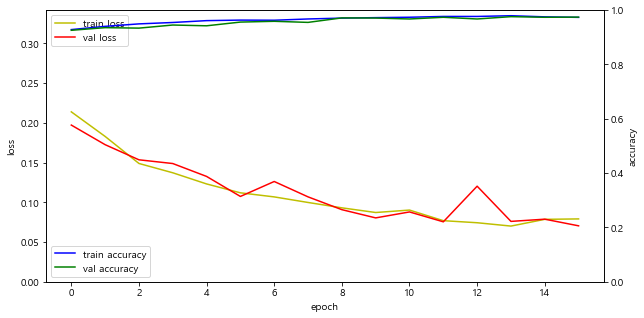

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 0.3419]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1]) # 0.0, 1: 0 ~ 100 %, 정확도임으로 변경하지 않음

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                832       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1950      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 3,103
Trainable params: 3,103
Non-trainable params: 0
_________________________________________________________________


In [13]:
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

손실값: 0.06939548890467738 /정확도: 98.46153855323792 %


In [14]:
model.save('./Wine2.h5')

In [15]:
pd = model.predict(x_test[0:100])

for i in range(len(x_test[0:100])):
    fmt = '실제값: {0}, 예측값: {1}'
    print(fmt.format(y_test[i], pd[i]), end='')
    
    if (pd[i] >= 0.5): # 임계값의 지정, 정확도를 참고하여 판단
        print('--> White 와인')  # 1
    else:
        print('--> Red 와인')    # 0

실제값: 1.0, 예측값: [0.99124014]--> White 와인
실제값: 0.0, 예측값: [0.0092383]--> Red 와인
실제값: 1.0, 예측값: [0.99626887]--> White 와인
실제값: 1.0, 예측값: [0.9997046]--> White 와인
실제값: 1.0, 예측값: [0.99605876]--> White 와인
실제값: 1.0, 예측값: [0.9999657]--> White 와인
실제값: 1.0, 예측값: [0.9938969]--> White 와인
실제값: 0.0, 예측값: [0.00036958]--> Red 와인
실제값: 0.0, 예측값: [0.00217068]--> Red 와인
실제값: 1.0, 예측값: [0.99003077]--> White 와인
실제값: 1.0, 예측값: [0.99991757]--> White 와인
실제값: 0.0, 예측값: [0.00043881]--> Red 와인
실제값: 1.0, 예측값: [0.9999927]--> White 와인
실제값: 1.0, 예측값: [0.9999964]--> White 와인
실제값: 1.0, 예측값: [0.99998236]--> White 와인
실제값: 1.0, 예측값: [0.999964]--> White 와인
실제값: 0.0, 예측값: [0.00088057]--> Red 와인
실제값: 1.0, 예측값: [0.9961902]--> White 와인
실제값: 1.0, 예측값: [0.9987205]--> White 와인
실제값: 1.0, 예측값: [0.74951744]--> White 와인
실제값: 1.0, 예측값: [0.9746609]--> White 와인
실제값: 1.0, 예측값: [0.91428953]--> White 와인
실제값: 1.0, 예측값: [0.95211446]--> White 와인
실제값: 1.0, 예측값: [0.9989346]--> White 와인
실제값: 1.0, 예측값: [0.9968254]--> White 와인
실제값: 1.0, 예측값: [0.99995

In [19]:
red = 0
white = 0
for i in range(len(y_test)):
    if y_test[i] == 1:  # White wine 인지 검사
        white = white + 1
    else:
        red = red + 1

print('Red wine 0:', red)
print('White wine 1:', white)

Red wine 0: 160
White wine 1: 490


In [22]:
# 결과 - 혼돈 행렬
print(x_test.shape)
y_test_pred = model.predict_classes(x_test)
c_matrix = confusion_matrix(y_test, y_test_pred) # 실제값, 예측값
print(c_matrix)

(650, 12)
[[151   9]
 [  1 489]]


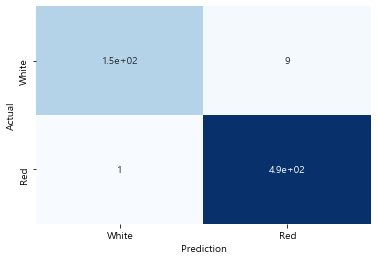

<Figure size 432x288 with 0 Axes>

In [23]:
ax = sb.heatmap(c_matrix, annot=True, 
                 xticklabels=['White', 'Red'], 
                 yticklabels=['White', 'Red'], cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
plt.show()
plt.clf()
# [[white wine 맞춘 갯수   white wine 틀린 갯수]
#  [red wine 틀린 갯수 red wine 맞춘 갯수]]

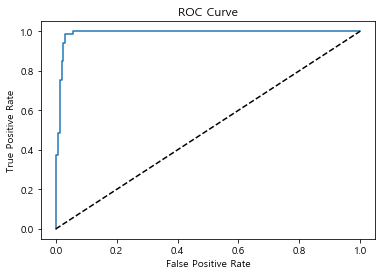

<Figure size 432x288 with 0 Axes>

In [24]:
# 결과 - ROC 곡선
y_test_pred_probs = model.predict(x_test)
FPR, TPR, _ = roc_curve(y_test, y_test_pred_probs)
plt.plot(FPR, TPR)
plt.plot([0,1],[0,1],'--', color='black') #diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
plt.clf()